In [1]:
!pip install emoji seaborn utility
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import emoji
%matplotlib inline

#importing rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit import RDConfig
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools as PandasTools
from rdkit import DataStructs
from rdkit.Chem.Subshape import SubshapeBuilder,SubshapeAligner,SubshapeObjects

#importing sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

In [2]:
!pip install shutil
class FeatureGenerator:

    def __init__(self, smiles):
        self.smiles = smiles
        self.temp_dir = tempfile.mkdtemp()

    def toString(self):
        return self.smiles

    def toSDF(self):
        # Try to get the rdkit mol
        mol = Chem.MolFromSmiles(self.smiles)
        #if mol == None: raise("Error in mol object")
        # Compute 2D coordinates
        AllChem.Compute2DCoords(mol)
        mol.SetProp("smiles", self.smiles)
        #self.sdf_filepath = os.path.join(self.temp_dir, "temp.sdf")
        w = Chem.SDWriter(os.path.join(self.temp_dir, "temp.sdf"))
        w.write(mol)
        w.flush()

    def toTPATF(self):
        features = []
        script_path = os.path.join(MAYACHEMTOOLS_DIR,
                                   "bin/TopologicalPharmacophoreAtomTripletsFingerprints.pl")
        self.toSDF()
        # Now generate the TPATF features
        # Check if the sdf file exists
        if not os.path.isfile(os.path.join(self.temp_dir, "temp.sdf")):
            print("Error: sdf file could not be created.")
            return None
        command = ("perl " + script_path + " -r " +
                   os.path.join(self.temp_dir, "temp") +
                   " --AtomTripletsSetSizeToUse FixedSize -v ValuesString -o "
                   + os.path.join(self.temp_dir, "temp.sdf"))
        os.system(command)

        with open(os.path.join(self.temp_dir, "temp.csv"), 'r') as f:
            for line in f.readlines():
                if "Cmpd" in line:
                    line = line.split(';')[5].replace('"','')
                    features = [int(i) for i in line.split(" ")]

        # Clean up the temporary files
        self._cleanup()
        return features

    def _cleanup(self):
        shutil.rmtree(self.temp_dir)

ERROR: Could not find a version that satisfies the requirement shutil (from versions: none)
ERROR: No matching distribution found for shutil


In [3]:
# Cell with constants
from pathlib import Path
DATADIR = Path("../data")
RANDOM_SEED = 2407

TMP_DIR = Path("../tmp")
TMP_DIR.mkdir(exist_ok=True)

train_df = pd.read_csv(DATADIR / "train.csv", index_col=0)
test_df = pd.read_csv(DATADIR / "test.csv", index_col=0)

In [4]:
train_df.describe()

,Smiles,Active
count,5557,5557
unique,5557,2
top,COc1ccc2[nH]cc(CCN)c2c1,False
freq,1,5351


In [5]:
molecules = train_df.Smiles.apply(Chem.MolFromSmiles)

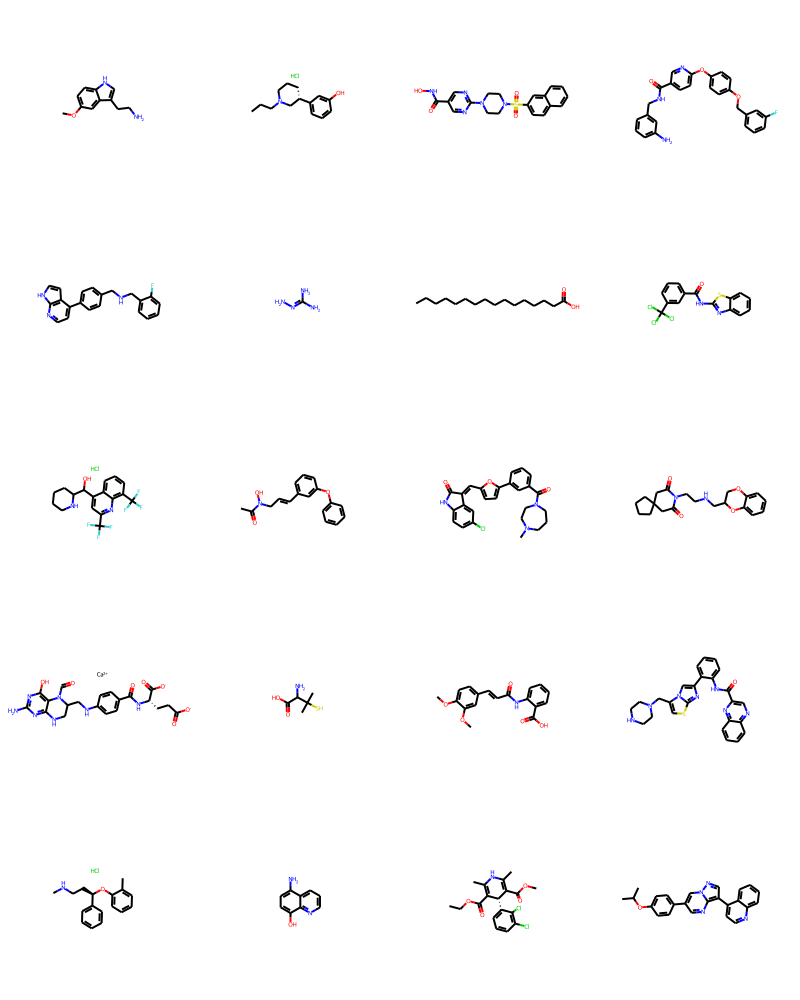

In [6]:
Draw.MolsToGridImage(molecules[:20],molsPerRow=4)

Tanimoto Similarity Coefficient of molecule_1 vs molecule_1: 1.0
Tanimoto Similarity Coefficient of molecule_1 vs molecule_2: 0.09523809523809523


Text(0.5, 1.0, 'Pairwise similarity all molecules')

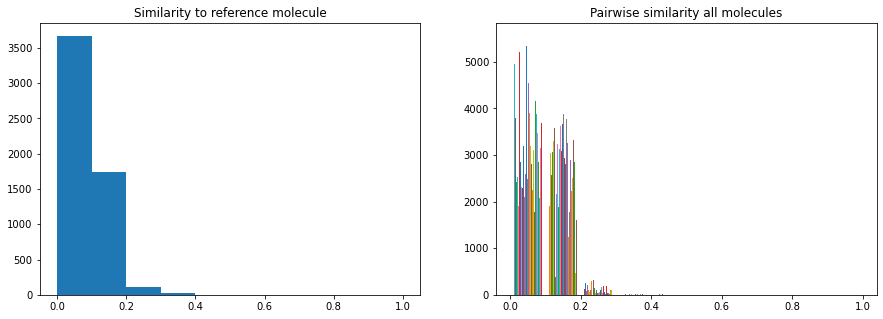

In [7]:
from rdkit import DataStructs
# We calculate Morgan fingerprints
mols_fps=[AllChem.GetMorganFingerprintAsBitVect(x,2) for x in molecules]
print(f'Tanimoto Similarity Coefficient of molecule_1 vs molecule_1: {DataStructs.TanimotoSimilarity(mols_fps[0],mols_fps[0])}')
print(f'Tanimoto Similarity Coefficient of molecule_1 vs molecule_2: {DataStructs.TanimotoSimilarity(mols_fps[0],mols_fps[1])}')

# Calculate similarities to reference molecule
sim_ref = DataStructs.BulkTanimotoSimilarity(mols_fps[0],mols_fps)

# Calculate pairwise similarities
def pairwise_sim(mols):
    pairwise=[]
    for i in mols:
        sim = DataStructs.BulkTanimotoSimilarity(i,mols)
        pairwise.append(sim)
    return pairwise

PW = pairwise_sim(mols_fps)
figure,(plt1,plt2) = plt.subplots(1,2)
figure.set_size_inches(15,5)
plt1.hist(sim_ref)
plt1.set_title('Similarity to reference molecule')
plt2.hist(PW)
plt2.set_title('Pairwise similarity all molecules')

In [8]:
from copy import deepcopy
data = train_df.copy(deep=True)

data.loc[:, 'MolLogP'] = molecules.apply(Descriptors.MolLogP)
data.loc[:, 'HeavyAtomCount'] = molecules.apply(Descriptors.HeavyAtomCount)
data.loc[:, 'HAccept'] = molecules.apply(Descriptors.NumHAcceptors)
data.loc[:, 'Heteroatoms'] = molecules.apply(Descriptors.NumHeteroatoms)
data.loc[:, 'HDonor'] = molecules.apply(Descriptors.NumHDonors)
data.loc[:, 'MolWt'] = molecules.apply(Descriptors.MolWt)
data.loc[:, 'RotableBonds'] = molecules.apply(Descriptors.NumRotatableBonds)
data.loc[:, 'RingCount'] = molecules.apply(Descriptors.RingCount)
data.loc[:, 'Ipc'] = molecules.apply(Descriptors.Ipc)
data.loc[:, 'HallKierAlpha'] = molecules.apply(Descriptors.HallKierAlpha)
data.loc[:, 'NumValenceElectrons'] = molecules.apply(Descriptors.NumValenceElectrons)
data.loc[:, 'SaturatedRings'] = molecules.apply(Descriptors.NumSaturatedRings)
data.loc[:, 'AliphaticRings'] = molecules.apply(Descriptors.NumAliphaticRings)
data.loc[:, 'AromaticRings'] = molecules.apply(Descriptors.NumAromaticRings)



In [80]:
from copy import deepcopy
data2 = test_df.copy(deep=True)

data2.loc[:, 'MolLogP'] = molecules.apply(Descriptors.MolLogP)
data2.loc[:, 'HeavyAtomCount'] = molecules.apply(Descriptors.HeavyAtomCount)
data2.loc[:, 'HAccept'] = molecules.apply(Descriptors.NumHAcceptors)
data2.loc[:, 'Heteroatoms'] = molecules.apply(Descriptors.NumHeteroatoms)
data2.loc[:, 'HDonor'] = molecules.apply(Descriptors.NumHDonors)
data2.loc[:, 'MolWt'] = molecules.apply(Descriptors.MolWt)
data2.loc[:, 'RotableBonds'] = molecules.apply(Descriptors.NumRotatableBonds)
data2.loc[:, 'RingCount'] = molecules.apply(Descriptors.RingCount)
data2.loc[:, 'Ipc'] = molecules.apply(Descriptors.Ipc)
data2.loc[:, 'HallKierAlpha'] = molecules.apply(Descriptors.HallKierAlpha)
data2.loc[:, 'NumValenceElectrons'] = molecules.apply(Descriptors.NumValenceElectrons)
data2.loc[:, 'SaturatedRings'] = molecules.apply(Descriptors.NumSaturatedRings)
data2.loc[:, 'AliphaticRings'] = molecules.apply(Descriptors.NumAliphaticRings)
data2.loc[:, 'AromaticRings'] = molecules.apply(Descriptors.NumAromaticRings)



In [9]:
data.head()

,Smiles,Active,MolLogP,HeavyAtomCount,HAccept,Heteroatoms,HDonor,MolWt,RotableBonds,RingCount,Ipc,HallKierAlpha,NumValenceElectrons,SaturatedRings,AliphaticRings,AromaticRings
0,COc1ccc2[nH]cc(CCN)c2c1,False,1.6777,14,2,3,2,190.246,3,2,2.660754e+03,-1.48,74,0,0,2
1,CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl,False,3.4034,17,2,3,1,255.789,3,2,5.649862e+03,-0.73,96,1,1,1
2,O=C(NO)c1cnc(N2CCN(S(=O)(=O)c3ccc4ccccc4c3)CC2...,False,1.2597,29,7,10,2,413.459,4,4,4.883254e+06,-3.08,150,1,1,3
3,Nc1cccc(CNC(=O)c2ccc(Oc3ccc(OCc4cccc(F)c4)cc3)...,False,5.1042,33,5,7,2,443.478,8,4,3.418901e+07,-4.39,166,0,0,4
4,Fc1ccccc1CNCc1ccc(-c2ccnc3[nH]ccc23)cc1,False,4.6588,25,2,4,2,331.394,5,4,1.115156e+06,-2.98,124,0,0,4


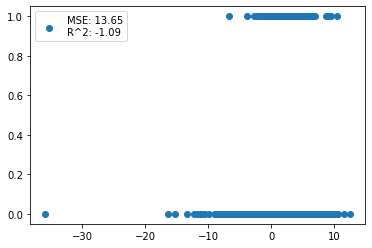

In [10]:
#importing sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
r2 = r2_score(data.MolLogP, data.Active)
mse = mean_squared_error(data.MolLogP, data.Active)
plt.scatter(data.MolLogP, data.Active,
            label = "MSE: {:.2f}\nR^2: {:.2f}".format(mse, r2))
plt.legend()
plt.show()

In [11]:
X = data.iloc[:, 3:]
y = data.Active
X.head()

,HeavyAtomCount,HAccept,Heteroatoms,HDonor,MolWt,RotableBonds,RingCount,Ipc,HallKierAlpha,NumValenceElectrons,SaturatedRings,AliphaticRings,AromaticRings
0,14,2,3,2,190.246,3,2,2.660754e+03,-1.48,74,0,0,2
1,17,2,3,1,255.789,3,2,5.649862e+03,-0.73,96,1,1,1
2,29,7,10,2,413.459,4,4,4.883254e+06,-3.08,150,1,1,3
3,33,5,7,2,443.478,8,4,3.418901e+07,-4.39,166,0,0,4
4,25,2,4,2,331.394,5,4,1.115156e+06,-2.98,124,0,0,4


In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Default models
models = {"rf": RandomForestRegressor(n_estimators=100, random_state=42)}

scores = {}
for m in models:
    print(1)
    models[m].fit(new_data, y_train)
    scores[m + "_train"] = models[m].score(new_data, y_train, )
    y_pred = models[m].predict(X_test)
    scores[m + "_test"] = r2_score(y_test, y_pred)
    scores[m + "_mse_test"] = mean_squared_error(y_test, y_pred)

1


In [42]:
new_data = X_train.astype(np.float32)

In [68]:
np.where(X_test.values >= max(np.float32))

TypeError: 'type' object is not iterable

In [56]:
scores

{'rf_train': 0.8563623303878143,
 'rf_test': -0.009015643514179494,
 'rf_mse_test': 0.039180074565347715}

In [57]:
scores = pd.Series(scores).T
scores

rf_train       0.856362
rf_test       -0.009016
rf_mse_test    0.039180
dtype: float64

In [58]:
param_grid = {
    'n_estimators': [200, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [59]:
estimator = RandomForestRegressor()
grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5)

In [61]:
grid.fit(new_data, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 700]})

In [62]:
grid.best_estimator_

RandomForestRegressor(max_features='log2', n_estimators=700)

In [81]:

models = {"rf": RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                                      max_features='log2', max_leaf_nodes=None,
                                      min_impurity_decrease=0.0,
                                      min_samples_leaf=1, min_samples_split=2,
                                      min_weight_fraction_leaf=0.0, n_estimators=700,
                                      n_jobs=None, oob_score=False, random_state=None,
                                      verbose=0, warm_start=False)}



scores = {}
X[X == np.inf] = 100
X[X == -np.inf] = -100
X[X == np.nan] = 0
X = X.astype(np.float32)
for m in models:
    models[m].fit(X, y)
    scores[m + "_train"] = models[m].score(X, y_train, )
#    scores[m + "_test"] = r2_score(y_test, y_pred)
#    scores[m + "_mse_test"] = mean_squared_error(y_test, y_pred)



/home/dmm2017/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


ValueError: Found input variables with inconsistent numbers of samples: [4445, 5557]

In [66]:
scores = pd.Series(scores).T
scores

rf_train       0.862749
rf_test        0.017411
rf_mse_test    0.038154
dtype: float64

In [78]:
np.any(X == np.inf)
X[X == np.inf] = 100
np.any(X == np.inf)

False

In [92]:
print(data2.head())
y_pred = models["rf"].predict(data2.iloc[:,2:])

                                              Smiles  MolLogP  HeavyAtomCount  \
0  COC(=O)Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5cc...   1.6777              14   
1                    O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12   3.4034              17   
2                      NC(CO)C(=O)NNCc1ccc(O)c(O)c1O   1.2597              29   
3       Nc1nc(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1Cl   5.1042              33   
4  Nc1ccc(C(=O)Nc2cccc(-c3nc(N4CCOCC4)c4oc5ncccc5...   4.6588              25   

   HAccept  Heteroatoms  HDonor    MolWt  RotableBonds  RingCount  \
0        2            3       2  190.246             3          2   
1        2            3       1  255.789             3          2   
2        7           10       2  413.459             4          4   
3        5            7       2  443.478             8          4   
4        2            4       2  331.394             5          4   

            Ipc  HallKierAlpha  NumValenceElectrons  SaturatedRings  \
0  2.660754e+03          -1

In [91]:
data.iloc[:, 2:]

,MolLogP,HeavyAtomCount,HAccept,Heteroatoms,HDonor,MolWt,RotableBonds,RingCount,Ipc,HallKierAlpha,NumValenceElectrons,SaturatedRings,AliphaticRings,AromaticRings
0,1.6777,14,2,3,2,190.246,3,2,2.660754e+03,-1.48,74,0,0,2
1,3.4034,17,2,3,1,255.789,3,2,5.649862e+03,-0.73,96,1,1,1
2,1.2597,29,7,10,2,413.459,4,4,4.883254e+06,-3.08,150,1,1,3
3,5.1042,33,5,7,2,443.478,8,4,3.418901e+07,-4.39,166,0,0,4
4,4.6588,25,2,4,2,331.394,5,4,1.115156e+06,-2.98,124,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5552,4.1991,38,9,11,1,520.494,5,6,8.060219e+08,-4.51,196,1,3,3
5553,1.8013,18,6,9,3,316.090,2,2,1.532480e+04,-2.16,94,0,0,2
5554,1.9404,11,2,2,1,145.161,0,2,5.057637e+02,-1.57,54,0,0,2
5555,5.5177,37,4,11,1,527.484,6,4,1.161221e+08,-3.02,198,1,1,3


In [96]:
y_pred[(y_pred > 0.5)] = True
y_pred[(y_pred <= 0.5)] = False

In [98]:
np.bool(y_pred)

/tmp/ipykernel_284809/3247074299.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.bool(y_pred)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [99]:
for i in test_df.index:
    test_df.loc[i, "Active"] = y_pred[i] > 0.5

In [100]:
test_df

,Smiles,Active
0,COC(=O)Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5cc...,False
1,O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12,False
2,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O,False
3,Nc1nc(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1Cl,False
4,Nc1ccc(C(=O)Nc2cccc(-c3nc(N4CCOCC4)c4oc5ncccc5...,False
...,...,...
1609,NS(=O)(=O)c1cc2c(cc1Cl)NC(C1CC3C=CC1C3)NS2(=O)=O,False
1610,Cc1cccc(Nc2ccncc2S(=O)(=O)NC(=O)NC(C)C)c1,False
1611,CCCC(=O)O[C@]1(C(=O)CO)CC[C@H]2[C@@H]3CCC4=CC(...,False
1612,CN(C)c1cccc(Oc2cnc(Nc3cccc(O)c3)nc2)c1,False


In [102]:
test_df.to_csv("../tmp/submission_pubchem_fingerprints-3-dima.csv")